In [32]:
'''Implementation of stein variational gradient descent for an SEIR model.'''

'Implementation of stein variational gradient descent for an SEIR model.'

In [33]:
from diffrax import ODETerm
from jax.scipy.stats import norm,poisson
from numpy.random import default_rng
import numpy as np
import diffrax
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt



In [34]:
beta = jnp.log(0.4)
eta = jnp.log(1/7)
gamma = jnp.log(1/14) #0.07
q = jnp.log(0.1)
mu = jnp.log(0.01)

t_vec = jnp.linspace(0,100,100)

def SEIR(t,y,args):
  beta,eta,gamma,q,mu = args

  beta = jnp.exp(beta)
  eta = jnp.exp(eta)
  gamma = jnp.exp(gamma)
  q = jnp.exp(q)
  mu = jnp.exp(mu)

  S,E,I,R = y
  N = S+E+I+R

  dS = - beta * ((E + q * I)/N) * S
  dE = beta * ((E + q * I)/N) * S - eta*E - gamma * E
  dI = eta * E - gamma * I - mu * I
  dR = gamma * E + gamma * I


  return jnp.array([dS,dE,dI,dR])

In [35]:
def model(ts,y0,par):
  solution = diffrax.diffeqsolve(
            ODETerm(SEIR),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            args=par,
            saveat=diffrax.SaveAt(ts=t_vec)
        )
  return solution.ys

rng_key = jax.random.PRNGKey(0)

y_true = model(t_vec,jnp.array([1000,1.,1.,0]),(beta,eta,gamma,q,mu))

rng = default_rng(1)

data_newI = rng.poisson(jnp.exp(eta) * y_true[:,1] + 0.005)

data_newD = rng.poisson(jnp.exp(mu) * y_true[:,2] + 0.005)


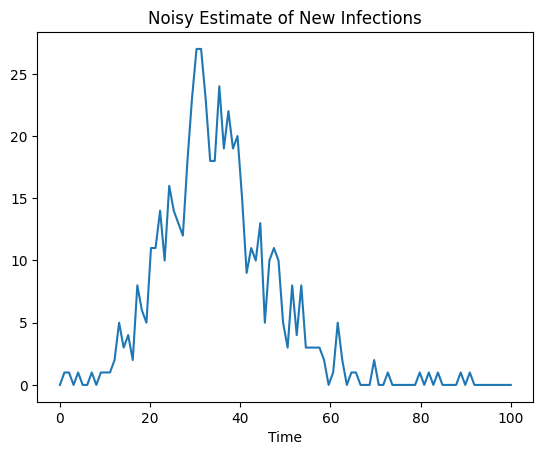

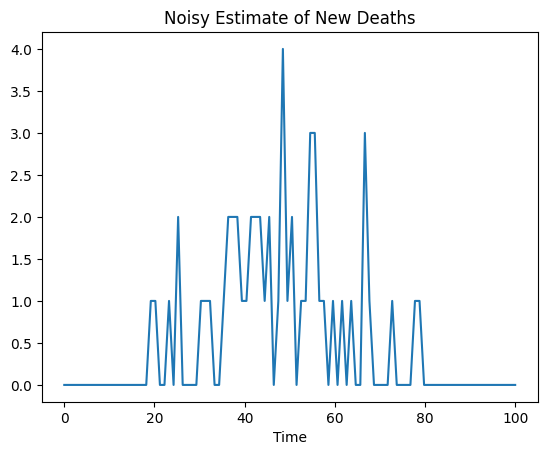

In [36]:
plt.title('Noisy Estimate of New Infections')
plt.plot(t_vec,data_newI)
plt.xlabel('Time')
plt.show()

plt.title('Noisy Estimate of New Deaths')
plt.xlabel('Time')
plt.plot(t_vec,data_newD)
plt.show()

In [37]:
@jax.jit
def log_likelihood(par):
  beta,eta,gamma,q,mu = par
  model_output = model(t_vec,jnp.array([1000.,1.,1.,0.]),(beta,eta,gamma,q,mu))
  model_output = jnp.clip(model_output,1e-8,None)
  return jnp.sum(poisson.logpmf(data_newI, jnp.exp(eta) * model_output[:,1]) + poisson.logpmf(data_newD,jnp.exp(mu) * model_output[:,2]))

In [38]:
gamma_rbf = 1.
def RBF_Kernel(x,x_prime,gamma): 
    sq_dist = jnp.sum((x-x_prime)**2)
    return jnp.exp(-gamma * sq_dist)

In [39]:
grad_logp = jax.vmap(jax.grad(log_likelihood),in_axes = (0,))
grad_kernel = jax.vmap(jax.grad(RBF_Kernel,argnums = (0,)),in_axes = (0,None,None))
vmap_kernel = jax.vmap(RBF_Kernel,in_axes = (0,None,None))
def optim_map(x,particles): 
    return jnp.mean(vmap_kernel(particles,x,gamma_rbf)[:,jnp.newaxis] * grad_logp(particles) + grad_kernel(particles,x,gamma_rbf)[0],axis = 0)


In [40]:
def update(particle,particles,step_size): 
    return particle + step_size * optim_map(particle,particles)

vmap_update = jax.jit(jax.vmap(update,in_axes = (0,None,None)))

In [41]:
iterations_sched = (100,5000,10000)
N = 500
step_size_sched = (0.001,0.00015, 0.0001)
rng_key = jax.random.key(0)
init_key,rng_key = jax.random.split(rng_key)

particles = jax.random.multivariate_normal(init_key,mean = jnp.log(0.1) * jnp.ones(5),cov = jnp.eye(5),shape = (N,))

for step_size,iterations in zip(step_size_sched,iterations_sched):
    print(f"Step size {step_size} for {iterations} iterations")
    for iter in range(iterations): 
        particles_copy = particles.copy()
        particles = vmap_update(particles,particles_copy,step_size)

        print(f"Mean of particles: {jnp.exp(jnp.mean(particles,axis = 0))}",end = '\r')
    print("\n")


Step size 0.001 for 100 iterations
Mean of particles: [0.24283981 0.06431834 0.05808458 0.11436001 0.06751253]

Step size 0.00015 for 5000 iterations
Mean of particles: [0.3494707  0.10528743 0.06696715 0.12515397 0.01795821]

Step size 0.0001 for 10000 iterations
Mean of particles: [0.37627402 0.12615643 0.07202651 0.12125159 0.01362439]



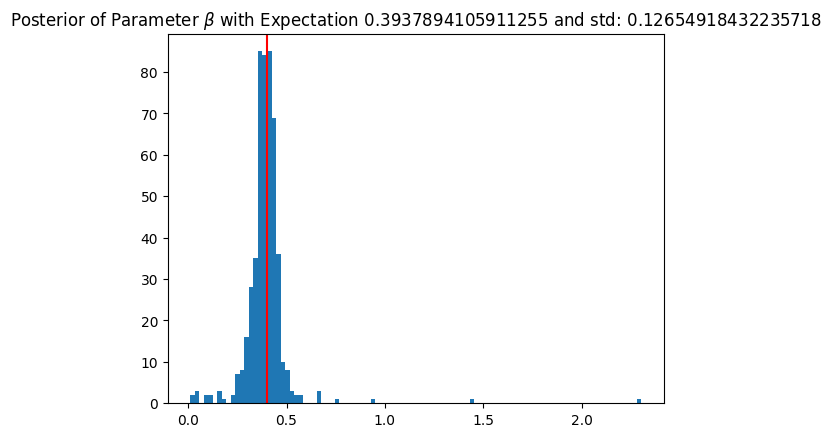

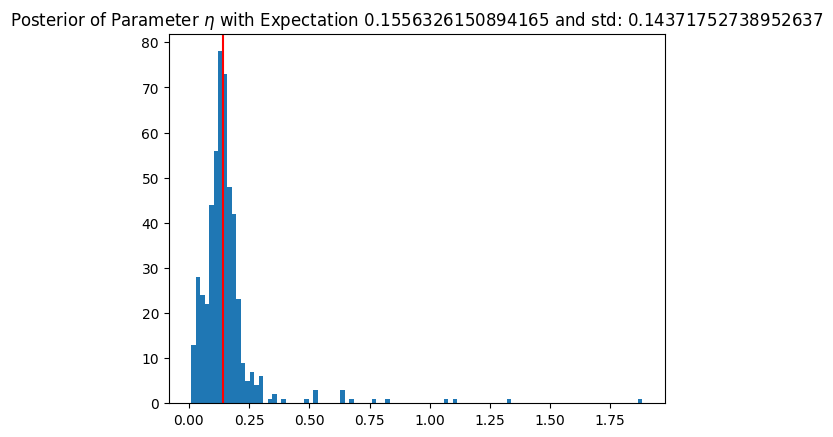

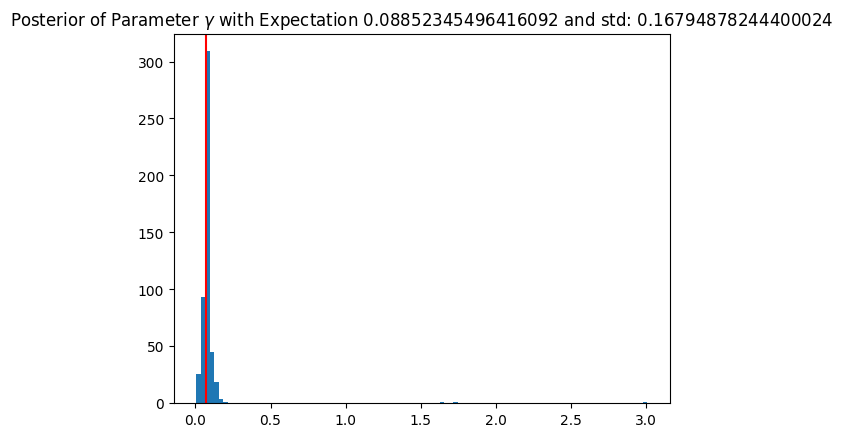

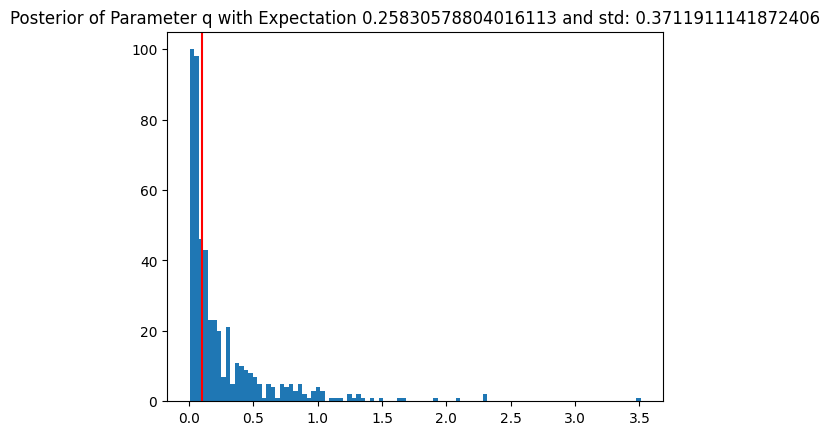

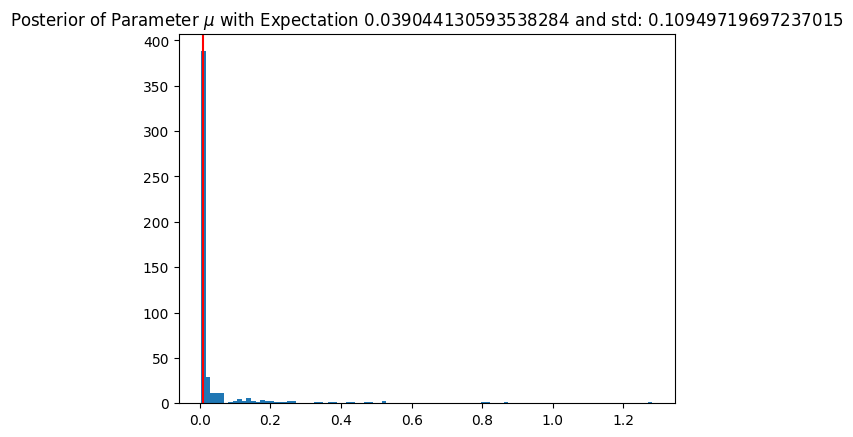

In [43]:
particles_exp = jnp.exp(particles)

plt.title(f"Posterior of Parameter $\\beta$ with Expectation {jnp.mean(particles_exp[:,0])} and std: {jnp.std(particles_exp[:,0])}")
plt.hist(particles_exp[:,0],bins = 100)
plt.axvline(jnp.exp(beta),color = 'red')
plt.show()

plt.title(f"Posterior of Parameter $\\eta$ with Expectation {jnp.mean(particles_exp[:,1])} and std: {jnp.std(particles_exp[:,1])}")
plt.hist(particles_exp[0:,1],bins = 100)
plt.axvline(jnp.exp(eta),color = 'red')
plt.show()

plt.title(f"Posterior of Parameter $\\gamma$ with Expectation {jnp.mean(particles_exp[:,2])} and std: {jnp.std(particles_exp[:,2])}")
plt.hist(particles_exp[0:,2],bins = 100)
plt.axvline(jnp.exp(gamma),color = 'red')
plt.show()

plt.title(f"Posterior of Parameter q with Expectation {jnp.mean(particles_exp[:,3])} and std: {jnp.std(particles_exp[:,3])}")
plt.hist(particles_exp[0:,3],bins = 100)
plt.axvline(jnp.exp(q),color = 'red')
plt.show()

plt.title(f"Posterior of Parameter $\\mu$ with Expectation {jnp.mean(particles_exp[:,4])} and std: {jnp.std(particles_exp[:,4])}")
plt.hist(particles_exp[0:,4],bins = 100)
plt.axvline(jnp.exp(mu),color = 'red')
plt.show()

